In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import urllib.request
from astropy.io import fits 
from astropy.table import Table
from scipy.special import gamma

from sklearn.decomposition import NMF, FastICA, PCA
from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

In [60]:
#Definición de funciones

#Grafica las decomposiciones
def plotdecom(decompositions):
    n_components=len(decompositions)
    fig = plt.figure(figsize=(5, 6))
    fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                        bottom=0.1, top=0.95, hspace=0.05)

    titles='PCA components'
    i=1

    for j in range(n_components):
        ax = fig.add_subplot(n_components,1,j+1)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 11999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(10**logwave, decompositions[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 11000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles)


        if j == 0:
            label = 'mean'
        else:
            label = 'component %i' % j

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)

    plt.show()



#Se crea función para hacer la descomposición
@pickle_results('spec_decompositions.pkl')
def compute_PCA(spectra,n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,pca.components_])
    return pca_comp



def mipca(spectra):
    '''
    spectra: espectros con los que se hará el pca
    
    Regresa los eigenvalues y eigenvectors
    '''
    spectraxnorm = np.array([spectra[i]-spectra.mean(1)[i] for i in range(spectra.shape[0])])
    spectranorm = np.array([spectraxnorm[i]/spectraxnorm.std(1)[i] for i in range(spectraxnorm.shape[0])])
    Cz = np.matmul(spectranorm.T,spectranorm)/(spectranorm.shape[1]-1)
    evals, evecs = np.linalg.eig(Cz)
    
    
    
    return evals,evecs



# Plot the sequence of reconstructions
def plotrecons(spec,spectra,coeff,wavelengths,evals_cs):
    spec_mean = spectra.mean(0)
    fig = plt.figure(figsize=(6, 14))
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

    for i, n in enumerate([0, 5, 20, 50, 100, 500, 1500, 3000, 4627]):
        ax = fig.add_subplot(911 + i)
        ax.plot(wavelengths, spec, '-', c='gray')
        ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())

        ax.set_ylim(-10, 25)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot} = %.3f)$" % evals_cs[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

        ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

    fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
    plt.show()

In [61]:
# Datos de descarga de primer archivo
url_file='https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits'
plates_local='./spPlates/'
plate_file='spPlate-3588-55184.fits'

# Crear carpeta si es que no existe ./spPlates/
if not os.path.exists(plates_local):
        os.makedirs(plates_local)

# Ruta completa al archivo
local_file = plates_local + plate_file

# Descargar si no existe o avisar si ya existe
if not os.path.exists(local_file):
    print("downloading spplate from %s to %s"
              % (url_file, local_file))
    tmp = urllib.request.urlretrieve(url_file, local_file)
else:
    print('%s  %s present on disk. '%(url_file,local_file))

https://data.sdss.org/sas/dr14/eboss/spectro/redux/v5_10_0/3587/spPlate-3587-55182.fits  ./spPlates/spPlate-3588-55184.fits present on disk. 


In [62]:
#Descarga de segundo archivo
DATA_URL="https://data.sdss.org/sas/dr14/eboss/qso/DR14Q/"
file="DR14Q_v4_4.fits"
local_dir="./"

# Ruta completa al archivo
local_file = os.path.join(local_dir,file)

# Descargar si no existe o avisar si ya existe
if not os.path.exists(file):
        print("downloading DR14 quasar dataset from %s to %s"
              % (DATA_URL+file, local_file ))
        tmp = urllib.request.urlretrieve(DATA_URL+local_file, local_file)
        print ("Downloaded file"+local_file)
else:
    print("%s already exist"%(local_file))

./DR14Q_v4_4.fits already exist


In [63]:
#Se abre el primer archivo
file = plates_local + plate_file
plate1 = fits.open(file)

#Separamos plugmap
plugmap = plate1['PLUGMAP'].data
objtype = plugmap['OBJTYPE']

#Se obtiene el flujo
flux = plate1[0].data

#Se obtiene el logaritmo de la longitud de onda
pltheader = plate1[0].header
coeff0 = pltheader['COEFF0']
coeff1 = pltheader['COEFF1']
logwave = coeff0 + coeff1 * np.arange(flux.shape[1])

#Se seleccionan los quasares
plugmap = plate1['PLUGMAP'].data
wq = plugmap['OBJTYPE'] == 'QSO'
fiberid_pm = plugmap['FIBERID']
fiberid_qso = fiberid_pm[wq]

In [64]:
#Se buscan aquellos quasares que filtramos del archivo anterior que estén el el catálogo del segundo archivo
catalog = Table.read('DR14Q_v4_4.fits');

cat = catalog[(catalog['MJD']==55184) & (catalog['PLATE']==3588)]
cat.sort('PLATE')
fiberid_cat = cat['FIBERID']

#fiberid_cat = catalog['FIBERID']

#id de Quasares que se encuentran tanto en el nuevo catalogo como en el archivo de spPlate
fbid_incat = fiberid_qso[np.in1d(fiberid_qso,fiberid_cat)]

In [65]:
Table(fiberid_cat)

col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36
-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16
510,756,730,740,776,266,248,780,232,834,214,194,858,886,864,888,304,42,338,342,494,531,552,548,546,542,544,470,570,442,608,366,657,626,358,694,2


In [66]:
catrec=cat[:][np.in1d(fiberid_cat,fbid_incat)]
#catrec=catalog[:][np.in1d(catalog['FIBERID'],fbid_incat)]
zmenos=catrec[catrec['Z']<2.1]
zmas=catrec[catrec['Z']>2.1]
fbid_incat_menos=fiberid_qso[np.in1d(fiberid_qso,zmenos['FIBERID'])]
fbid_incat_mas=fiberid_qso[np.in1d(fiberid_qso,zmas['FIBERID'])]

In [67]:
#Se buscan los redshifts de los quasares en el catálogo filtrado (cat)
#z=catalog[:][np.in1d(catalog['FIBERID'],fbid_incat)]
z=cat['Z'][np.in1d(cat['FIBERID'],fbid_incat)]

In [68]:
#Se buscan los redshifts de los quasares en el catálogo completo
fiberid_catalogo=catalog['FIBERID']
fbid_incat_full=fiberid_qso[np.in1d(fiberid_qso,fiberid_cat)]

In [69]:
#Visualización de los espectros en sistema de referencia en reposo
lrf = [10**logwave/(1+z[i]) for i in range(len(z))]
spectra = np.array([flux[fbid_incat[i]-1] for i in range(len(z))])
spectramas = np.array([flux[fbid_incat_mas[i]-1] for i in range(len(fbid_incat_mas))])
spectramenos = np.array([flux[fbid_incat_menos[i]-1] for i in range(len(fbid_incat_menos))])
spectrafull = np.array([flux[fbid_incat_full[i]-1] for i in range(len(fbid_incat_full))])

# plt.figure(figsize=(15,30),dpi=100)
# i=0
# for i in range(9):
#     plt.subplot(5,2,i+1)
#     plt.plot(lrf[i],spectra[i],label=objtype[fbid_incat[i]-1]+'_'+str(fbid_incat[i])+' z=%.3f'%z[i])
#     plt.ylabel(r'Flux 1E-17 erg/cm^2/s/Ang')
#     plt.xlabel(r'\lambda [\Ang]')
#     plt.ylim(-5,10)
#     plt.legend()

In [70]:
#Se fija la cantidad de componentes
n_components = 5
decompositions = compute_PCA(spectra,n_components)
n_components = 5
decompositionsfull = compute_PCA(spectrafull,n_components)


# n_components = 5
# decompositionsmas = compute_PCA(spectramas,n_components)
# n_components = 2
# decompositionsmenos = compute_PCA(spectramenos,n_components)


@pickle_results: using precomputed results from 'spec_decompositions.pkl'
@pickle_results: using precomputed results from 'spec_decompositions.pkl'


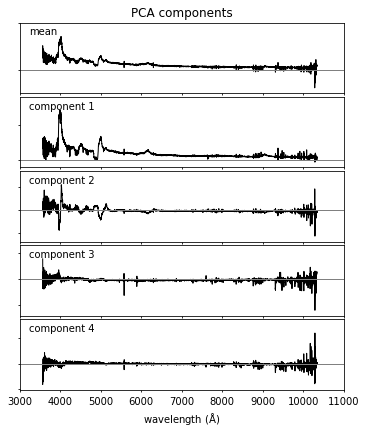

In [14]:
#Visualización de descomposición de cat
plotdecom(decompositions)

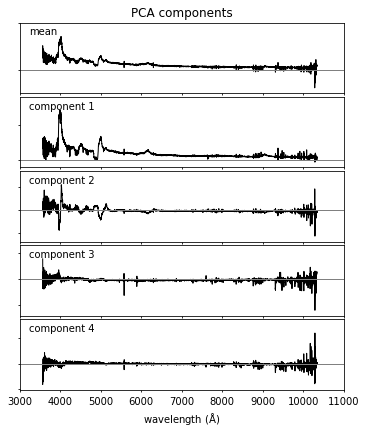

In [15]:
#Visualización de descomposición de catalogo
plotdecom(decompositionsfull)

In [16]:
#Se obtienen eigenvalores y eigenvectores
evals, evecs = mipca(spectra)
evalsmas, evecsmas = mipca(spectramas)
evalsmenos, evecsmenos = mipca(spectramenos)
evalsfull, evecsfull = mipca(spectrafull)

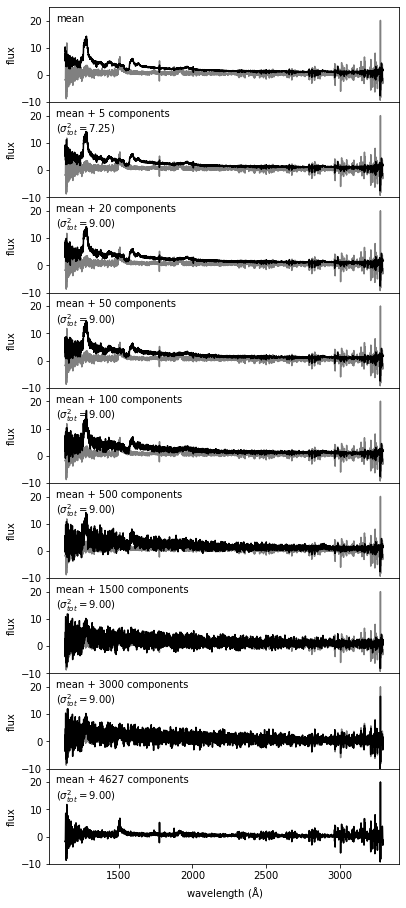

In [42]:
#Se calculan los coeficientes para un espectro en específico
spec = spectra[4]
coeff = np.dot(evecs, spec - spectra.mean(0))
evals_cs = evals.cumsum()
plotrecons(spec,spectra,coeff,lrf[4],evals_cs)

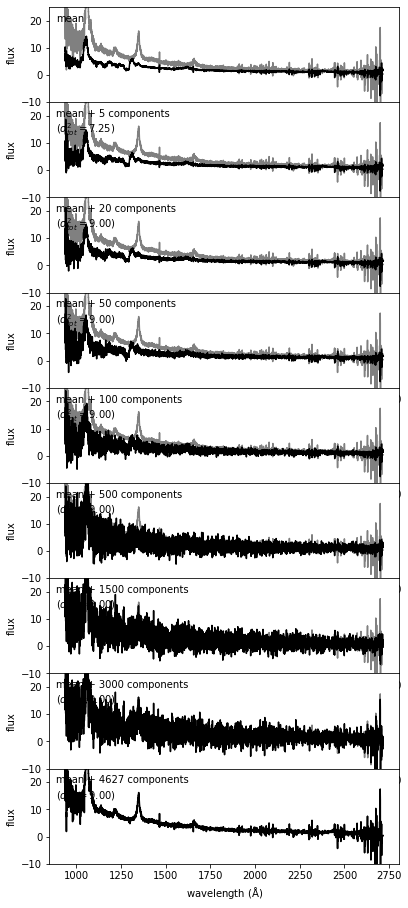

In [43]:
spec = spectrafull[1]
coef = np.dot(evecsfull, spec - spectrafull.mean(0))
evalsfull_cs = evalsfull.cumsum()
plotrecons(spec,spectrafull,coef,lrf[1],evalsfull_cs)

<BarContainer object of 9 artists>

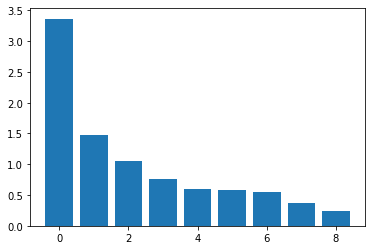

In [58]:
plt.bar(range(len(evals[:9])),evals[:9])